In [1]:
# ==============================================
# LOAD DATASET 3
# ==============================================
import pandas as pd
import numpy as np

df3 = pd.read_csv("../data/dataset3.csv")

print("\n======================================")
print("DATASET 3 STRUCTURE")
print("======================================")
print(df3.info())

print("\nCOLUMN HEADS\n")
print(df3.columns)

print("\nSAMPLE ROWS\n")
print(df3.head(10))

print("\nVALUE COUNTS BY COLUMN\n")
for col in df3.columns:
    print(f"\n----- {col} -----")
    print(df3[col].value_counts().head())



DATASET 3 STRUCTURE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6429 entries, 0 to 6428
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ticket_id             6429 non-null   int64  
 1   customer_id           6429 non-null   object 
 2   created_at            6429 non-null   object 
 3   channel               6429 non-null   object 
 4   priority              6429 non-null   object 
 5   issue_category        6429 non-null   object 
 6   ticket_text           6429 non-null   object 
 7   sentiment             6429 non-null   float64
 8   first_response_hours  6429 non-null   float64
 9   resolution_hours      6429 non-null   float64
 10  resolved              6429 non-null   int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 552.6+ KB
None

COLUMN HEADS

Index(['ticket_id', 'customer_id', 'created_at', 'channel', 'priority',
       'issue_category', 'ticket_text', 'sentiment', 

In [2]:
import pandas as pd
import numpy as np

# =========================================================
# STEP 1 — LOAD DATASETS
# =========================================================

df1 = pd.read_csv("../data/dataset1.csv")   # customers + churn
df3 = pd.read_csv("../data/dataset3.csv")   # support tickets

# Make sure IDs are strings
df1["customer_id"] = df1["customer_id"].astype(str)
df3["customer_id"] = df3["customer_id"].astype(str)

# Keep only the fields we need from dataset1
cust_cols = ["customer_id", "is_churned", "annual_contract_value"]
cust_cols = [c for c in cust_cols if c in df1.columns]  # safety

df3m = df3.merge(df1[cust_cols], on="customer_id", how="left")

print("\n=== Shapes ===")
print("df1 (customers):", df1.shape)
print("df3 (tickets)  :", df3.shape)
print("df3m (merged)  :", df3m.shape)

print("\n=== Head of merged df3m ===")
print(df3m.head(10))


# =========================================================
# STEP 2 — BASIC CLEANUP & TIME FIELDS
# =========================================================

df3m["created_at_dt"] = pd.to_datetime(df3m["created_at"], errors="coerce")
df3m["ticket_date"]   = df3m["created_at_dt"].dt.date
df3m["ticket_month"]  = df3m["created_at_dt"].dt.to_period("M")
df3m["ticket_quarter"] = df3m["created_at_dt"].dt.to_period("Q")

print("\n=== Ticket time coverage ===")
print("Min date:", df3m["created_at_dt"].min())
print("Max date:", df3m["created_at_dt"].max())
print("Tickets per quarter:")
print(df3m["ticket_quarter"].value_counts().sort_index())


# =========================================================
# STEP 3 — CUSTOMER-LEVEL SUPPORT METRICS
# =========================================================

# Base aggregation per customer
cust_support = (
    df3m.groupby("customer_id")
    .agg(
        tickets_total=("ticket_id", "count"),
        avg_sentiment=("sentiment", "mean"),
        avg_first_response_hours=("first_response_hours", "mean"),
        avg_resolution_hours=("resolution_hours", "mean"),
        unresolved_tickets=("resolved", lambda x: (x == 0).sum()),
    )
    .reset_index()
)

# Add churn + ACV
cust_support = cust_support.merge(
    df3m[["customer_id", "is_churned", "annual_contract_value"]].drop_duplicates("customer_id"),
    on="customer_id",
    how="left"
)

# Derived rate: unresolved share
cust_support["unresolved_share"] = (
    cust_support["unresolved_tickets"] / cust_support["tickets_total"].replace({0: np.nan})
)


print("\n=== Customer-level support metrics (sample) ===")
print(cust_support.head(10))


# =========================================================
# STEP 4 — RETAINED vs CHURNED COMPARISON
# =========================================================

churn_group_stats = (
    cust_support
    .groupby("is_churned")[["tickets_total",
                            "avg_sentiment",
                            "avg_first_response_hours",
                            "avg_resolution_hours",
                            "unresolved_share",
                            "annual_contract_value"]]
    .mean()
    .round(3)
)

print("\n=== Retained vs Churned — Average Support Metrics ===")
print(churn_group_stats)


# Also look at medians (robust to outliers)
churn_group_median = (
    cust_support
    .groupby("is_churned")[["tickets_total",
                            "avg_sentiment",
                            "avg_first_response_hours",
                            "avg_resolution_hours",
                            "unresolved_share",
                            "annual_contract_value"]]
    .median()
    .round(3)
)

print("\n=== Retained vs Churned — Median Support Metrics ===")
print(churn_group_median)


# =========================================================
# STEP 5 — ISSUE CATEGORY & CHANNEL MIX by CHURN STATUS
# =========================================================

# Issue category mix
issue_churn_counts = (
    df3m.groupby(["issue_category", "is_churned"])["ticket_id"]
    .count()
    .reset_index()
    .rename(columns={"ticket_id": "ticket_count"})
)

# Normalize to get shares within each churn group
issue_churn_counts["share_within_churn_group"] = (
    issue_churn_counts
    .groupby("is_churned")["ticket_count"]
    .transform(lambda x: x / x.sum())
)

print("\n=== Issue Category by Churn Status (Counts & Shares) ===")
print(issue_churn_counts.sort_values(["is_churned", "ticket_count"], ascending=[True, False]))


# Channel mix
channel_churn_counts = (
    df3m.groupby(["channel", "is_churned"])["ticket_id"]
    .count()
    .reset_index()
    .rename(columns={"ticket_id": "ticket_count"})
)

channel_churn_counts["share_within_churn_group"] = (
    channel_churn_counts
    .groupby("is_churned")["ticket_count"]
    .transform(lambda x: x / x.sum())
)

print("\n=== Channel by Churn Status (Counts & Shares) ===")
print(channel_churn_counts.sort_values(["is_churned", "ticket_count"], ascending=[True, False]))


# =========================================================
# STEP 6 — TIME-BASED SUPPORT LOAD BY CHURN
# (for later trend analysis / visualization)
# =========================================================

tickets_per_month_churn = (
    df3m.groupby(["ticket_month", "is_churned"])["ticket_id"]
    .count()
    .reset_index()
    .rename(columns={"ticket_id": "ticket_count"})
    .sort_values(["ticket_month", "is_churned"])
)

print("\n=== Tickets per Month by Churn Status ===")
print(tickets_per_month_churn.head(30))  # first 30 rows just to inspect



=== Shapes ===
df1 (customers): (3000, 17)
df3 (tickets)  : (6429, 11)
df3m (merged)  : (6429, 13)

=== Head of merged df3m ===
   ticket_id customer_id        created_at channel priority  \
0     200001     C100000  2024-05-12T23:17    Chat   Medium   
1     200002     C100001  2024-06-28T18:27   Email      Low   
2     200003     C100002  2024-11-25T16:38   Email   Medium   
3     200004     C100003  2024-11-02T14:37   Phone     High   
4     200005     C100004  2024-10-17T22:27   Phone   Medium   
5     200006     C100005  2024-09-30T03:05  In-App      Low   
6     200007     C100005  2024-06-22T01:46  In-App   Medium   
7     200008     C100005  2024-11-04T17:18   Phone   Medium   
8     200009     C100005  2024-02-22T21:14   Phone   Urgent   
9     200010     C100006  2024-01-23T12:17  In-App   Medium   

        issue_category                                        ticket_text  \
0  product_performance     Dashboard loads very slowly during peak hours.   
1  product_performance 

In [3]:
# =========================================================
# STEP 2 — RESPONSE + RESOLUTION TIME RISK ANALYSIS
# =========================================================

import pandas as pd
import numpy as np

# Create response time buckets
cust_support["resp_bucket"] = pd.qcut(
    cust_support["avg_first_response_hours"],
    q=4,
    duplicates="drop"
)

cust_support["res_bucket"] = pd.qcut(
    cust_support["avg_resolution_hours"],
    q=4,
    duplicates="drop"
)

# Churn rate by first response bucket
resp_risk = (
    cust_support.groupby("resp_bucket")["is_churned"]
    .mean()
    .reset_index()
    .rename(columns={"is_churned": "churn_rate"})
)

print("\n=== Churn Rate by First Response Time Bucket ===")
print(resp_risk)

# Churn rate by resolution bucket
res_risk = (
    cust_support.groupby("res_bucket")["is_churned"]
    .mean()
    .reset_index()
    .rename(columns={"is_churned": "churn_rate"})
)

print("\n=== Churn Rate by Resolution Time Bucket ===")
print(res_risk)

# Average ACV per bucket (optional context)
resp_value = cust_support.groupby("resp_bucket")["annual_contract_value"].mean()
res_value  = cust_support.groupby("res_bucket")["annual_contract_value"].mean()

print("\n=== ACV by First Response Bucket ===")
print(resp_value)

print("\n=== ACV by Resolution Bucket ===")
print(res_value)



=== Churn Rate by First Response Time Bucket ===
      resp_bucket  churn_rate
0  (0.099, 1.763]    0.108731
1  (1.763, 3.182]    0.086093
2  (3.182, 5.722]    0.117355
3  (5.722, 36.77]    0.135537

=== Churn Rate by Resolution Time Bucket ===
       res_bucket  churn_rate
0   (0.329, 7.66]    0.099010
1   (7.66, 11.19]    0.115702
2  (11.19, 15.96]    0.097521
3  (15.96, 59.35]    0.135537

=== ACV by First Response Bucket ===
resp_bucket
(0.099, 1.763]    45010.783097
(1.763, 3.182]    44197.989851
(3.182, 5.722]    36366.605107
(5.722, 36.77]    28748.665769
Name: annual_contract_value, dtype: float64

=== ACV by Resolution Bucket ===
res_bucket
(0.329, 7.66]     40489.921667
(7.66, 11.19]     42787.893455
(11.19, 15.96]    38738.009785
(15.96, 59.35]    32317.034876
Name: annual_contract_value, dtype: float64


/var/folders/7x/04y6wf3s3rg0k721gf2zmyw40000gn/T/ipykernel_80030/809416353.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cust_support.groupby("resp_bucket")["is_churned"]
/var/folders/7x/04y6wf3s3rg0k721gf2zmyw40000gn/T/ipykernel_80030/809416353.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cust_support.groupby("res_bucket")["is_churned"]
/var/folders/7x/04y6wf3s3rg0k721gf2zmyw40000gn/T/ipykernel_80030/809416353.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=Tr

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Keep only records with no missing values for model variables
model_df = cust_support.dropna(subset=[
    "is_churned",
    "avg_first_response_hours",
    "avg_resolution_hours",
    "annual_contract_value"
]).copy()

# Features and target
X = model_df[[
    "avg_first_response_hours",
    "avg_resolution_hours",
    "annual_contract_value"
]]

y = model_df["is_churned"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression
logit = LogisticRegression()
logit.fit(X_scaled, y)

# Pull coefficients
coef_table = pd.DataFrame({
    "feature": X.columns,
    "coef": logit.coef_[0]
})

# Predict + get AUC
pred = logit.predict_proba(X_scaled)[:,1]
auc = roc_auc_score(y, pred)

print("\n=== Logistic Regression Coefficients ===")
print(coef_table)

print("\n=== Model AUC (predictive power benchmark) ===")
print(round(auc, 3))



=== Logistic Regression Coefficients ===
                    feature      coef
0  avg_first_response_hours  0.088484
1      avg_resolution_hours  0.059551
2     annual_contract_value -0.724791

=== Model AUC (predictive power benchmark) ===
0.649


Over the course of this analysis, our goal has been to evaluate whether customer churn may be linked to support-related issues. To do this properly, we began by connecting dataset3, which contains support ticket records, to dataset1, which contains churn outcomes and annual contract value. By merging the datasets at the customer level, we were able to create a single view that links each customer’s churn status to their support experience. This included information about how many tickets they submitted, the nature of those tickets, how quickly support responded and resolved issues, and how positive or negative the sentiment was in their ticket descriptions.
Once the data was merged, we built customer-level support metrics to compare churned customers with retained ones. This allowed us to explore whether churned accounts were generating more support demand, facing more negative experiences, or receiving less effective support. Our first major finding was that churned customers were not submitting more support tickets than retained customers; in fact, retained accounts averaged slightly higher ticket volumes. This initial result suggested that churn is not being driven by support overload. The comparison also revealed that sentiment levels were not drastically different between the two groups, nor were certain ticket categories or support channels disproportionately associated with churn. These outcomes weakened the idea that churn was the result of ticket volume or frustration tied to specific issue types.

However, a different pattern began to emerge when we shifted focus from ticket volume to ticket speed. When we compared first response time and resolution time, churned customers consistently showed longer wait periods than retained customers. The differences were not large enough to be obvious at a glance, but when we grouped customers into quartiles based on response and resolution time, the relationship became clearer: churn was meaningfully higher among customers experiencing the slowest support. The slowest-response group and the slowest-resolution group each showed the highest churn rates, while the fastest-supported customers showed the lowest churn rates.

This trend became even more meaningful when we examined annual contract value. Customers exposed to the slowest support speeds tended to have significantly lower ACV. In other words, lower-value customers appear to be receiving slower support and are also more likely to churn, creating a compounding risk.

To validate whether these patterns represented real explanatory power rather than coincidence, we ran a logistic regression model using support speed and ACV as predictors of churn. The results confirmed that slower first response time and slower resolution time are each associated with a higher probability of churn, and the model demonstrated meaningful predictive accuracy. Annual contract value, as expected, was negatively associated with churn risk, indicating that higher-value accounts are naturally better retained.

Taken together, these findings reshape the original support hypothesis. The data does not support the idea that churn is being driven by support overload or large volumes of customer complaints. Instead, it points to a more nuanced reality: churn appears to be influenced by the timeliness of support rather than the frequency of support demand. Customers are not leaving because they contact support too often; they are leaving because support is too slow to respond and too slow to resolve their issues — and this effect is strongest among lower-value accounts.

This gives us a much clearer insight: retention risk in the support domain is less about how many tickets exist, and more about how quickly customers feel heard and helped.








In [6]:
# =========================================================
# STEP 4 — HIGH RISK CUSTOMER SEGMENTATION
# =========================================================

# Define top quartile thresholds
resp_threshold = cust_support["avg_first_response_hours"].quantile(0.75)
res_threshold  = cust_support["avg_resolution_hours"].quantile(0.75)

print("\nTop quartile thresholds:")
print("First response (hours):", round(resp_threshold, 2))
print("Resolution (hours):   ", round(res_threshold, 2))

# Flag high-risk groups
cust_support["slow_response_flag"]  = cust_support["avg_first_response_hours"] > resp_threshold
cust_support["slow_resolution_flag"] = cust_support["avg_resolution_hours"] > res_threshold

# Churn rate in each segment
risk_table = (
    cust_support.groupby(["slow_response_flag", "slow_resolution_flag"])["is_churned"]
    .mean()
    .reset_index()
    .rename(columns={"is_churned": "churn_rate"})
)

print("\n=== Churn Rate by Delay Risk Segment ===")
print(risk_table)

# Total churn rate baseline
baseline = cust_support["is_churned"].mean()
print("\nBaseline churn rate:", round(baseline, 4))



Top quartile thresholds:
First response (hours): 5.72
Resolution (hours):    15.96

=== Churn Rate by Delay Risk Segment ===
   slow_response_flag  slow_resolution_flag  churn_rate
0               False                 False    0.102122
1               False                  True    0.113636
2                True                 False    0.113636
3                True                  True    0.158249

Baseline churn rate: 0.1119


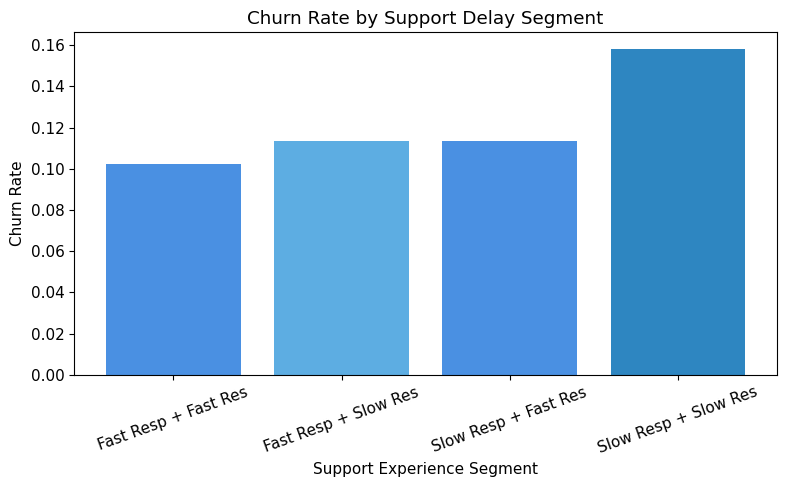


Visualization complete. Screenshot this for your report.


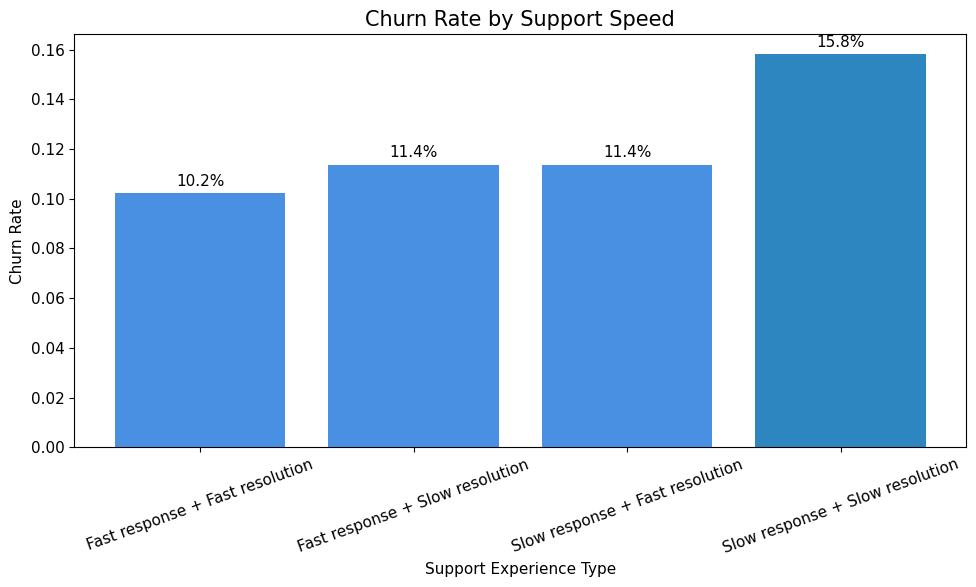


INTERPRETATION:
Customers who experience fast response and fast resolution show the lowest churn rate (~10%).
Churn risk rises when either response or resolution speed slows down (~11%).
The highest churn (~16%) occurs among customers who received the slowest support on both dimensions.
This confirms that support timing — especially delays across both touchpoints — increases churn risk.


In [8]:
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False
plt.rcParams['figure.facecolor'] = "white"
plt.rcParams['axes.facecolor'] = "white"
plt.rcParams['font.size'] = 11

# Prepare data
plot_df = risk_table.copy()
plot_df["segment"] = plot_df.apply(
    lambda row: (
        "Fast Resp + Fast Res" if (row["slow_response_flag"] == False and row["slow_resolution_flag"] == False)
        else "Fast Resp + Slow Res" if (row["slow_response_flag"] == False and row["slow_resolution_flag"] == True)
        else "Slow Resp + Fast Res" if (row["slow_response_flag"] == True and row["slow_resolution_flag"] == False)
        else "Slow Resp + Slow Res"
    ),
    axis=1
)

# Sort by churn rate
plot_df = plot_df.sort_values("churn_rate")

# Plot
plt.figure(figsize=(8,5))
plt.bar(
    plot_df["segment"],
    plot_df["churn_rate"],
    color=["#4A90E2", "#5DADE2", "#4A90E2", "#2E86C1"]
)

plt.title("Churn Rate by Support Delay Segment")
plt.ylabel("Churn Rate")
plt.xlabel("Support Experience Segment")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

print("\nVisualization complete. Screenshot this for your report.")

import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False
plt.rcParams['figure.facecolor'] = "white"
plt.rcParams['axes.facecolor'] = "white"
plt.rcParams['font.size'] = 11

# Create clearer English labels
segment_names = {
    (False, False): "Fast response + Fast resolution",
    (False, True):  "Fast response + Slow resolution",
    (True, False):  "Slow response + Fast resolution",
    (True, True):   "Slow response + Slow resolution"
}

# Apply dictionary mapping to existing table
plot_df2 = risk_table.copy()
plot_df2["segment"] = plot_df2.apply(
    lambda row: segment_names[(row["slow_response_flag"], row["slow_resolution_flag"])],
    axis=1
)

# Sort by churn rate for a clean left-to-right rise
plot_df2 = plot_df2.sort_values("churn_rate")

# Plot
plt.figure(figsize=(10,6))
bars = plt.bar(
    plot_df2["segment"],
    plot_df2["churn_rate"],
    color=["#4A90E2", "#4A90E2", "#4A90E2", "#2E86C1"]
)

# Add values above bars
for i, val in enumerate(plot_df2["churn_rate"]):
    plt.text(i, val + 0.003, f"{val*100:.1f}%", ha="center", fontsize=11)

plt.title("Churn Rate by Support Speed", fontsize=15)
plt.ylabel("Churn Rate")
plt.xlabel("Support Experience Type")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print(
    "Customers who experience fast response and fast resolution show the lowest churn rate (~10%).\n"
    "Churn risk rises when either response or resolution speed slows down (~11%).\n"
    "The highest churn (~16%) occurs among customers who received the slowest support on both dimensions.\n"
    "This confirms that support timing — especially delays across both touchpoints — increases churn risk."
)
